# Model and predict oil consumption with sklearn models

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

## Get data

In [2]:
data_per_day = pd.read_pickle('../data/processed/data_one_day_clean.pickle')

In [3]:
data_per_day.isna().sum()

Tank-ID                                   0
Zeitstempel                               0
Füllstand                                 0
Linear Prozentwert                        0
Sensorwert                                0
Leerstand                                 0
Maximale Füllgrenze                       0
Temperatur                                0
Sensorlage                                0
PLZ                                       0
Breitengrad                               0
Längengrad                                0
Sicherheitsbestand wird erreicht am    1645
Meldebestand wird erreicht am          1645
Verbrauch                                 0
Verbrauch smoothed                        0
dtype: int64

In [4]:
# convert date columns from object to datetime
date_cols = ['Zeitstempel', 'Sicherheitsbestand wird erreicht am', 'Meldebestand wird erreicht am']
for col in date_cols:
    data_per_day[col] = pd.to_datetime(data_per_day[col])

In [5]:
# Target
#for id in data_per_day["Tank-ID"].unique():
#    temp_df = pd.DataFrame(data_per_day[data_per_day["Tank-ID"] == id])
#    temp_df["Verbrauch"] = temp_df["Füllstand"].diff()

In [6]:
# Saisonal trend
from scipy.ndimage import uniform_filter1d

df_saisonal = data_per_day[["Zeitstempel", "Verbrauch"]].groupby("Zeitstempel").mean()
df_saisonal.loc[:, "Saisonaler Trend"] = uniform_filter1d(df_saisonal["Verbrauch"], 11)
df_saisonal.drop("Verbrauch", axis=1, inplace=True)
df_saisonal.reset_index(inplace=True)
data_per_day = data_per_day.merge(df_saisonal, on=['Zeitstempel'], how='left')

In [7]:
from src.api import WeatherAPI

weather_api = WeatherAPI()

merged_dfs = []
for id in data_per_day["Tank-ID"].unique():
    temp_df = data_per_day[data_per_day["Tank-ID"] == id]

    # get attributes
    latitude = temp_df["Längengrad"].iloc[0]
    longitude = temp_df["Breitengrad"].iloc[0]
    if temp_df["Zeitstempel"].dtypes == 'object':
        temp_df["Zeitstempel"] = pd.to_datetime(temp_df["Zeitstempel"])
    start_date = temp_df["Zeitstempel"].min().strftime("%Y-%m-%d")
    end_date = temp_df["Zeitstempel"].max().strftime("%Y-%m-%d")
    #print("Start date:", start_date, "End date:", end_date, "Day difference:", (temp_df["Zeitstempel"].max() - temp_df["Zeitstempel"].min()).days)

    # get matching weather data
    weather_data = weather_api.get_data(latitude, longitude, start_date, end_date)

    # remove timezone information
    weather_data['date'] = weather_data['date'].dt.tz_localize(None)
    weather_data = weather_data.rename(columns={'date': 'Zeitstempel'})

    # join
    #print("Data shape before merge:", temp_df.shape)
    temp_df = temp_df.merge(weather_data, on=['Zeitstempel'], how='left')
    #print("Data shape after merge:", temp_df.shape)
    #display(temp_df.head(5))

    # append
    merged_dfs.append(temp_df)

merged_data = pd.concat(merged_dfs)
df = merged_data.set_index('Zeitstempel')

In [8]:
df.isna().sum()

Tank-ID                                   0
Füllstand                                 0
Linear Prozentwert                        0
Sensorwert                                0
Leerstand                                 0
Maximale Füllgrenze                       0
Temperatur                                0
Sensorlage                                0
PLZ                                       0
Breitengrad                               0
Längengrad                                0
Sicherheitsbestand wird erreicht am    1645
Meldebestand wird erreicht am          1645
Verbrauch                                 0
Verbrauch smoothed                        0
Saisonaler Trend                          0
temperature_2m_max                        0
temperature_2m_min                        0
temperature_2m_mean                       6
apparent_temperature_max                  0
apparent_temperature_min                  0
apparent_temperature_mean                 6
sunshine_duration               

In [9]:
# drop irrelevant columns
cols_to_drop = ["Sicherheitsbestand wird erreicht am", "Meldebestand wird erreicht am"] # "Füllstand"
df = df.drop(cols_to_drop, axis=1)
# drop ID 5
df = df[df['Tank-ID'] != 5]

In [10]:
# Remove positive peaks 
for c in ["Verbrauch", "Verbrauch smoothed", "Saisonaler Trend"]:
    df.loc[df[c] > 0, c] = 0.0
    df[c] = df[c].abs()

## Visualize the data

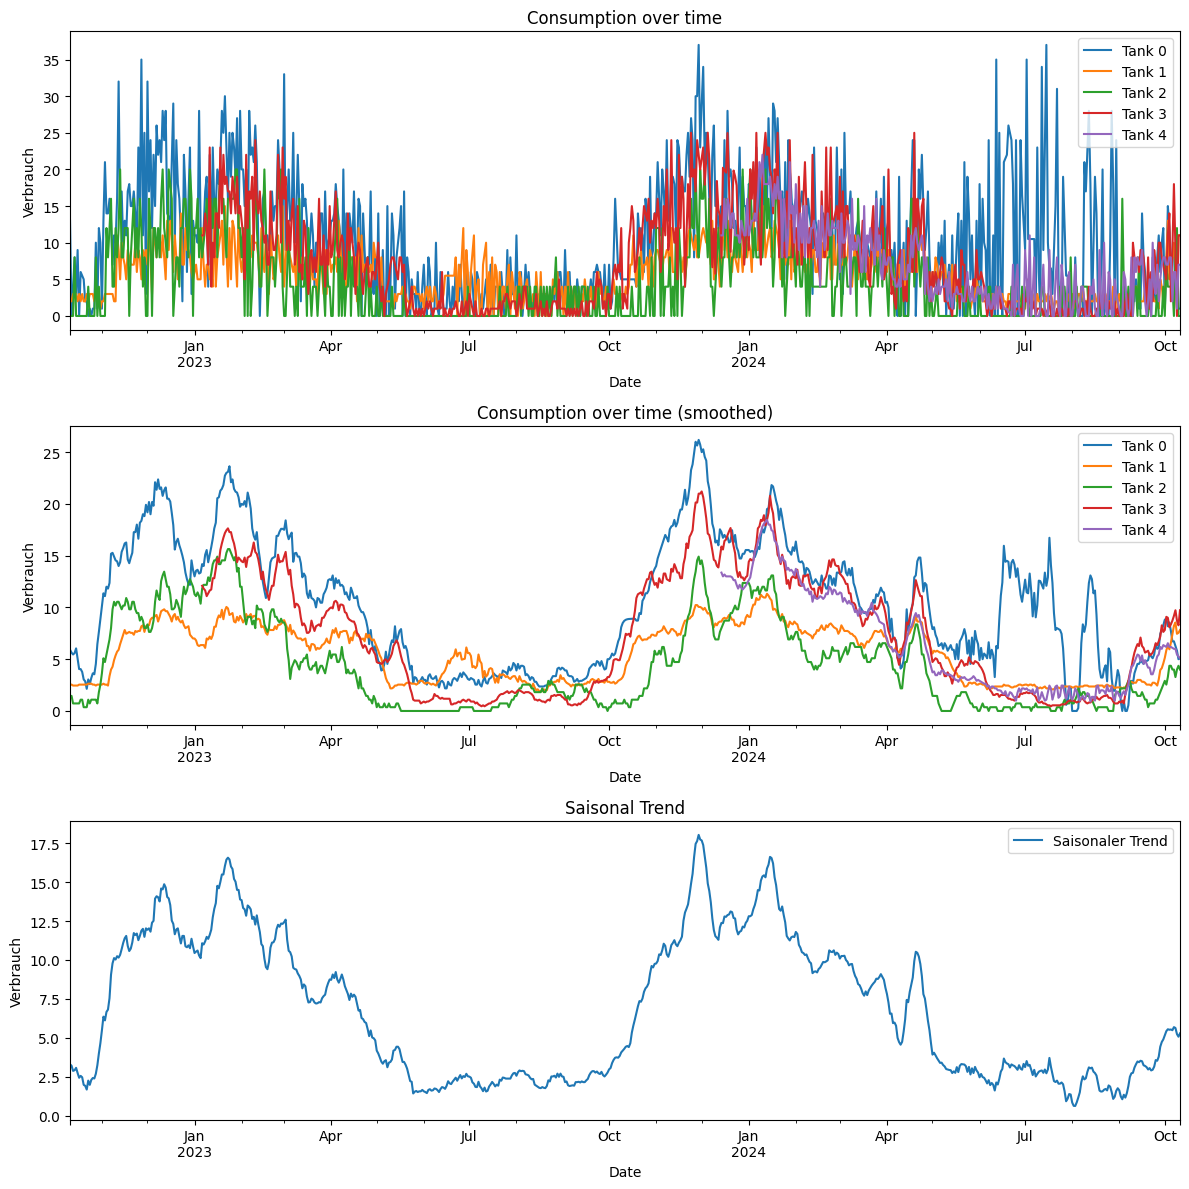

In [11]:
# plot target "Verbrauch" time series based on tank ID
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
for tank_id in df["Tank-ID"].unique():
    df[df["Tank-ID"] == tank_id]["Verbrauch"].plot(ax=axes[0], label=f'Tank {tank_id}')
    df[df["Tank-ID"] == tank_id]["Verbrauch smoothed"].plot(ax=axes[1], label=f'Tank {tank_id}')
df[df["Tank-ID"] == 1]["Saisonaler Trend"].plot(ax=axes[2], label=f'Saisonaler Trend')

axes[0].set_title('Consumption over time')
axes[1].set_title('Consumption over time (smoothed)')
axes[2].set_title('Saisonal Trend')

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel('Verbrauch')
    ax.legend()

plt.tight_layout()
plt.show()

## Sklearn models

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error

In [20]:
regressors = [
    LinearRegression(),
    Ridge(random_state=42),
    Lasso(random_state=42),
    KernelRidge(),
    SVR(),
    NuSVR(),
    LinearSVR(random_state=42),
    DecisionTreeRegressor(random_state=42),
    ExtraTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42)
]

In [13]:
# split data into train and test data, based on tank ID
train_data = df[df['Tank-ID'] != 2]
test_data = df[df['Tank-ID'] == 2]

# get x and y values
X_train = train_data.drop('Verbrauch', axis=1).values
y_train = train_data['Verbrauch'].values
X_test = test_data.drop('Verbrauch', axis=1).values
y_test = test_data['Verbrauch'].values

In [26]:
df = df.ffill()

In [27]:
# Train one model per tank id
tank_ids = df["Tank-ID"].unique()
for regressor in regressors:
    rmse_scores = {}
    for id in tank_ids:
        #regressor = DecisionTreeRegressor(random_state=42)
        rmse_scores[id] = []
        df_tmp = df[df["Tank-ID"] == id]

        # CV
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        y = df_tmp["Verbrauch"].values
        X = df_tmp.drop("Verbrauch", axis=1).values
        for i, (train_index, test_index) in enumerate(kf.split(X)):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            # Train the model
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
        
            # Calculate the mean squared error for this fold
            rmse = root_mean_squared_error(y_test, y_pred)
            rmse_scores[id].append(rmse)

    # Print results
    print(f"{regressor}")
    rmse_over_all_tanks = []
    for tank in rmse_scores.keys():
        rmse_over_all_tanks.append(np.mean(rmse_scores[tank]))
        print(f"Tank-ID {tank}: {np.mean(rmse_scores[tank])}")
    print(f"Overall {np.mean(rmse_over_all_tanks)}\n")

LinearRegression()
Tank-ID 0: 5.782498854275188
Tank-ID 1: 2.140520000212155
Tank-ID 2: 3.501246179132612
Tank-ID 3: 14.817512755271423
Tank-ID 4: 8.708593724320034
Overall 6.990074302642282
Ridge(random_state=42)
Tank-ID 0: 5.759598590245529
Tank-ID 1: 2.131925046041539
Tank-ID 2: 3.4962176650538397
Tank-ID 3: 14.798217736174374
Tank-ID 4: 8.830862004986132
Overall 7.003364208500282
Lasso(random_state=42)
Tank-ID 0: 5.732859253277546
Tank-ID 1: 2.1807667430066213
Tank-ID 2: 3.4987597674793625
Tank-ID 3: 3.2875549099678514
Tank-ID 4: 2.5337905018926703
Overall 3.446746235124811


/home/moros/projects/BFH2024/bfh24/venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e+02, tolerance: 2.174e+00
  model = cd_fast.enet_coordinate_descent(


KernelRidge()
Tank-ID 0: 5.759577785762948
Tank-ID 1: 2.1319214578465484
Tank-ID 2: 3.49621700852762
Tank-ID 3: 14.798299795046967
Tank-ID 4: 8.830853804701349
Overall 7.003373970377086
SVR()
Tank-ID 0: 8.227243320237216
Tank-ID 1: 3.4443086868336854
Tank-ID 2: 5.505206111380484
Tank-ID 3: 6.694875643681092
Tank-ID 4: 5.412599135899393
Overall 5.856846579606374
NuSVR()
Tank-ID 0: 8.274828865300298
Tank-ID 1: 3.4048482141948107
Tank-ID 2: 5.505776122132583
Tank-ID 3: 6.651059983417957
Tank-ID 4: 5.311257028918345
Overall 5.8295540427927985


/home/moros/projects/BFH2024/bfh24/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/moros/projects/BFH2024/bfh24/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/moros/projects/BFH2024/bfh24/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/moros/projects/BFH2024/bfh24/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/moros/projects/BFH2024/bfh24/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/moro

LinearSVR(random_state=42)
Tank-ID 0: 9.042549610937327
Tank-ID 1: 3.72195330476998
Tank-ID 2: 6.77264258409335
Tank-ID 3: 9.464673246955098
Tank-ID 4: 5.612269059582276
Overall 6.922817561267607
DecisionTreeRegressor(random_state=42)
Tank-ID 0: 8.500461792484217
Tank-ID 1: 2.979273313770814
Tank-ID 2: 4.855395556956568
Tank-ID 3: 5.059682959380686
Tank-ID 4: 3.887780615894252
Overall 5.0565188476973075
ExtraTreeRegressor(random_state=42)
Tank-ID 0: 8.888236649974406
Tank-ID 1: 3.2566843452382686
Tank-ID 2: 4.847324776533713
Tank-ID 3: 4.912512803277797
Tank-ID 4: 3.853351714687227
Overall 5.151622057942282
RandomForestRegressor(random_state=42)
Tank-ID 0: 6.4451615973295215
Tank-ID 1: 2.375205807589477
Tank-ID 2: 3.7848095382118627
Tank-ID 3: 3.6200583849812915
Tank-ID 4: 2.8993217955557533
Overall 3.824911424733581
